<a href="https://colab.research.google.com/github/K-107/Anomaly-Detection/blob/main/LSTM_Autoencoder_Anomaly_Detection_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# https://quokkas.tistory.com/entry/LSTM-Autoencoder%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%9C-ECG-%EC%9D%B4%EC%83%81-%ED%83%90%EC%A7%80 에서 참고



## ECG Anomaly Detection

In [2]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

# set random seed
seed(10)
tf.random.set_seed(10)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Data loading and pre-processing

In [34]:
# 깃클론해서 깃허브에서 데이터 가져오기

!git clone https://github.com/jang-hs/LSTM_Autoencoder_Anomaly_Detection_ECG.git

fatal: destination path 'LSTM_Autoencoder_Anomaly_Detection_ECG' already exists and is not an empty directory.


In [35]:
%cd /content/LSTM_Autoencoder_Anomaly_Detection_ECG/data/ecg

/content/LSTM_Autoencoder_Anomaly_Detection_ECG/data/ecg


In [36]:
# The ECG dataset containing a single anomaly corresponding to a pre-ventricular contraction
# dataset from http://www.cs.ucr.edu/~eamonn/discords/
import pickle
train_data_dir= 'chfdb_chf01_275_train.pkl'
test_data_dir= 'chfdb_chf01_275_test.pkl'
with open(train_data_dir, 'rb') as f:
    train_raw = pickle.load(f)
with open(test_data_dir, 'rb') as f:
    test_raw = pickle.load(f)

In [37]:
train_raw[:10], pd.DataFrame(train_raw).shape

([[-0.645, 0.665, 0.0],
  [-0.635, 0.71, 0.0],
  [-0.645, 0.745, 0.0],
  [-0.635, 0.76, 0.0],
  [-0.645, 0.785, 0.0],
  [-0.63, 0.79, 0.0],
  [-0.63, 0.815, 0.0],
  [-0.635, 0.835, 0.0],
  [-0.625, 0.86, 0.0],
  [-0.645, 0.87, 0.0]],
 (1833, 3))

In [38]:
#only use target 1 & target 2
train = pd.DataFrame(train_raw,columns=['Target1','Target2','label']).iloc[:,:2]
test = pd.DataFrame(test_raw,columns=['Target1','Target2','label']).iloc[:,:2]

In [39]:
train

,Target1,Target2
0,-0.645,0.665
1,-0.635,0.710
2,-0.645,0.745
3,-0.635,0.760
4,-0.645,0.785
...,...,...
1828,-0.700,0.575
1829,-0.700,0.600
1830,-0.735,0.625
1831,-0.730,0.645


In [40]:
test

,Target1,Target2
0,-0.720,0.700
1,-0.700,0.695
2,-0.695,0.720
3,-0.710,0.715
4,-0.715,0.725
...,...,...
1836,-0.555,0.625
1837,-0.575,0.645
1838,-0.565,0.660
1839,-0.555,0.655


In [41]:
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (1833, 2)
Test dataset shape: (1841, 2)


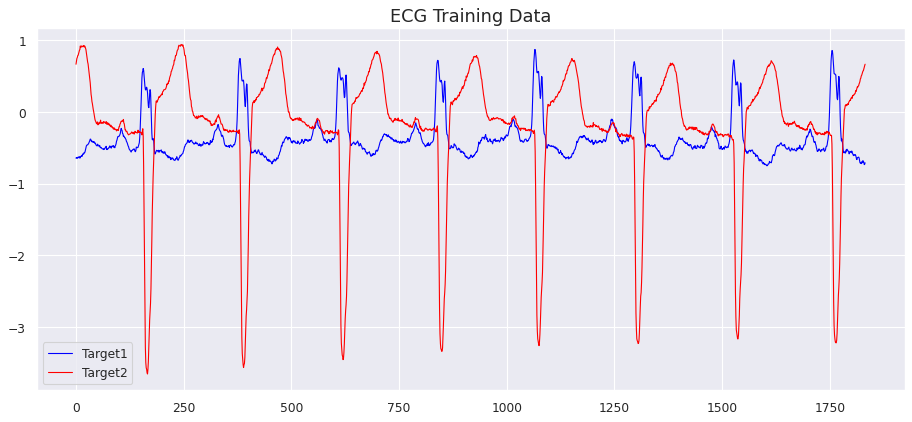

In [42]:
# train data plot
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Target1'], label='Target1', color='blue', animated = True, linewidth=1)
ax.plot(train['Target2'], label='Target2', color='red', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('ECG Training Data', fontsize=16)
plt.show()

In [43]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "real_scaler_data"
joblib.dump(scaler, scaler_filename)

# https://cloud.google.com/ai-platform/prediction/docs/exporting-for-prediction?hl=ko
# joblib.dump는 저장할 때 쓴다!

['real_scaler_data']

In [44]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (1833, 1, 2)
Test data shape: (1841, 1, 2)


## 아니... timesteps가 1이면 왜하는겨...?

In [45]:
# define the autoencoder network model
def autoencoder_model(X): 
    inputs = Input(shape=(X.shape[1], X.shape[2])) # [timesteps, features]
    L1 = LSTM(24, return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(10, return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2) # timesteps에 맞춰야한다.
    L4 = LSTM(10, return_sequences=True)(L3)
    L5 = LSTM(24, return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

# https://stackoverflow.com/questions/51749404/how-to-connect-lstm-layers-in-keras-repeatvector-or-return-sequence-true
# RepeatVector 설명

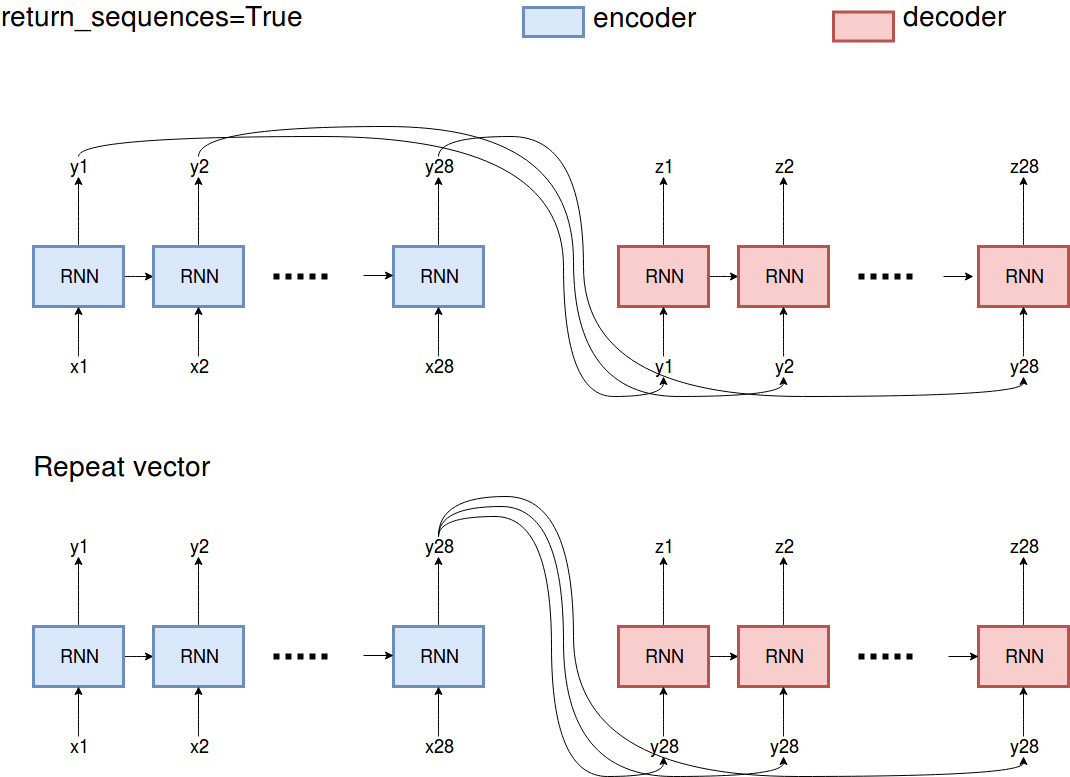

In [15]:
# https://webnautes.tistory.com/1525

'''
LSTM레이어에서
WARNING:tensorflow:Layer lstm_4 will not use cuDNN kernels since it doesn't meet the criteria.
It will use a generic GPU kernel as fallback when running on GPU.
에러가 나면 activation='relu'을 지워라!!

L2 = LSTM(10, activation='relu', return_sequences=False)(L1)
'''

"\nLSTM레이어에서\nWARNING:tensorflow:Layer lstm_4 will not use cuDNN kernels since it doesn't meet the criteria.\nIt will use a generic GPU kernel as fallback when running on GPU.\n에러가 나면 activation='relu'을 지워라!!\n\nL2 = LSTM(10, activation='relu', return_sequences=False)(L1)\n"

In [46]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 2)]            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 24)             2592      
_________________________________________________________________
lstm_9 (LSTM)                (None, 10)                1400      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 1, 10)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 10)             840       
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 24)             3360      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 2)              50  

In [47]:
# fit the model to the data
nb_epochs = 100
batch_size = 20
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
88/88 [==============================] - 9s 28ms/step - loss: 0.3860 - val_loss: 0.2721
Epoch 2/100
88/88 [==============================] - 1s 9ms/step - loss: 0.1122 - val_loss: 0.1938
Epoch 3/100
88/88 [==============================] - 1s 10ms/step - loss: 0.0956 - val_loss: 0.1803
Epoch 4/100
88/88 [==============================] - 1s 9ms/step - loss: 0.0884 - val_loss: 0.1618
Epoch 5/100
88/88 [==============================] - 1s 9ms/step - loss: 0.0782 - val_loss: 0.1419
Epoch 6/100
88/88 [==============================] - 1s 9ms/step - loss: 0.0678 - val_loss: 0.1297
Epoch 7/100
88/88 [==============================] - 1s 9ms/step - loss: 0.0595 - val_loss: 0.1151
Epoch 8/100
88/88 [==============================] - 1s 9ms/step - loss: 0.0524 - val_loss: 0.0977
Epoch 9/100
88/88 [==============================] - 1s 9ms/step - loss: 0.0466 - val_loss: 0.0878
Epoch 10/100
88/88 [==============================] - 1s 9ms/step - loss: 0.0431 - val_loss: 0.0817
Epoch 1

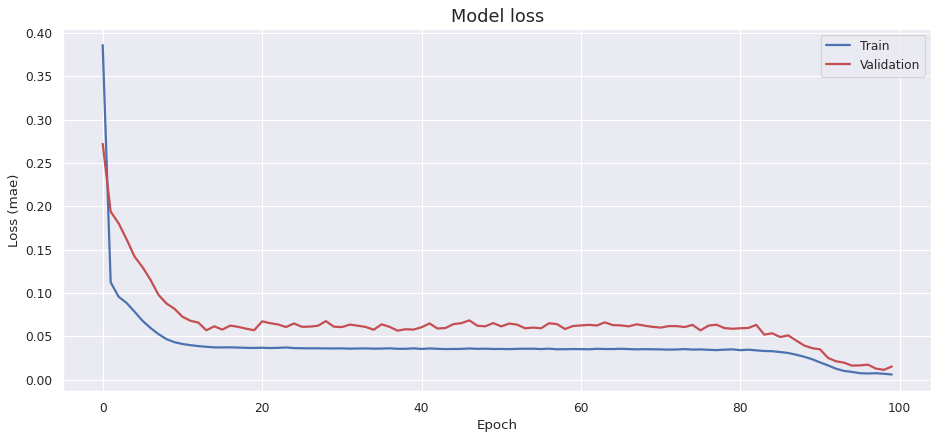

In [48]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function

In [49]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.1)

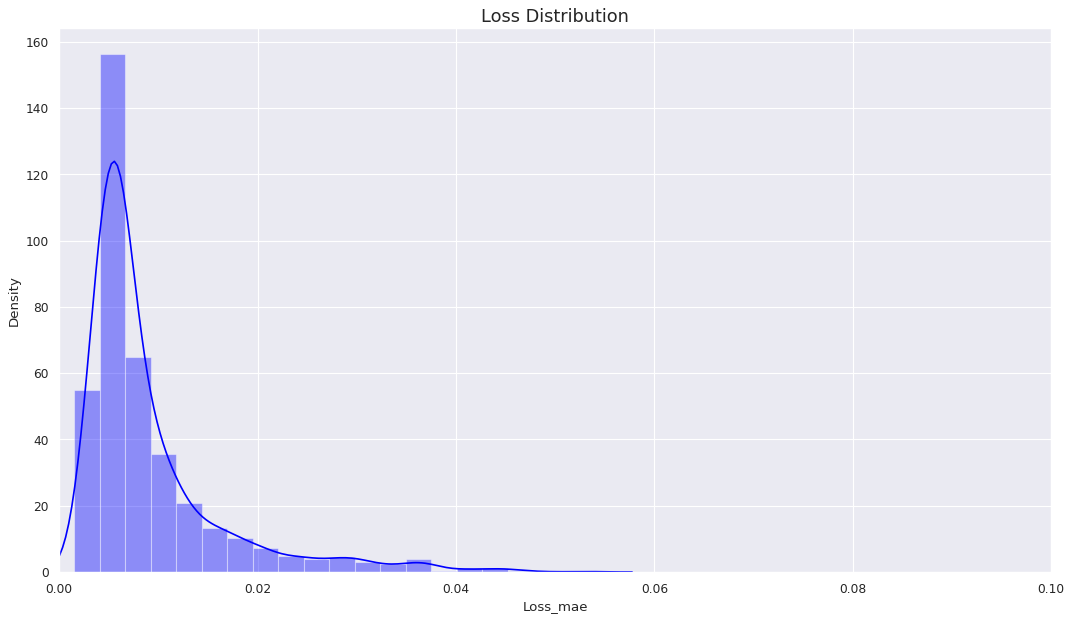

In [50]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index) # 깡통이다
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,0.1])

In [51]:
scored

,Loss_mae
0,0.012185
1,0.011495
2,0.012614
3,0.011781
4,0.012868
...,...
1828,0.017439
1829,0.017544
1830,0.021823
1831,0.021312


In [52]:
# calculate the loss on the test set
print('anomaly threshold = {}'.format(np.percentile(scored,100)))
threshold = np.percentile(scored,100)

X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

anomaly threshold = 0.052907414938446584


,Loss_mae,Threshold,Anomaly
0,0.020418,0.052907,False
1,0.018040,0.052907,False
2,0.017628,0.052907,False
3,0.019321,0.052907,False
4,0.019980,0.052907,False


In [53]:
scored['Anomaly'].unique()

array([False,  True])

In [54]:
scored[scored['Anomaly']==True]

,Loss_mae,Threshold,Anomaly
513,0.059435,0.052907,True
514,0.069836,0.052907,True
515,0.090394,0.052907,True
516,0.116290,0.052907,True
517,0.139206,0.052907,True
...,...,...,...
1086,0.063688,0.052907,True
1087,0.068691,0.052907,True
1088,0.070374,0.052907,True
1089,0.057490,0.052907,True


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:486: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


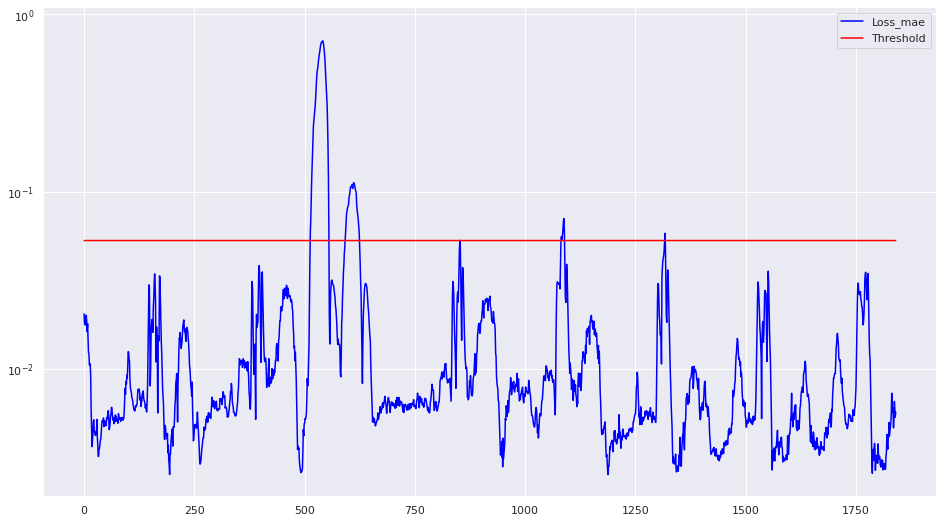

In [55]:
# test set에 대한 결과
scored.plot(logy=True,  figsize=(16,9), ylim=[0,1.10], color=['blue','red'])

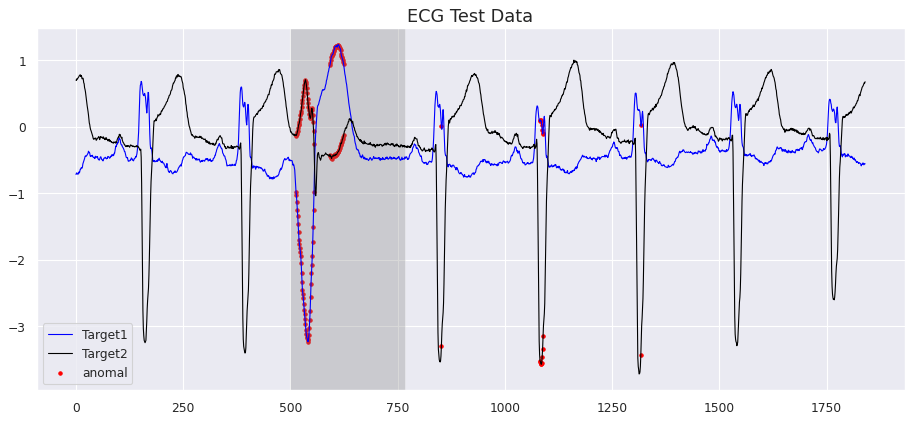

In [56]:
#whole test data
test_ = pd.DataFrame(test_raw,columns=['Target1','Target2','label'])

#make plot
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_['Target1'], label='Target1', color='blue', animated = True, linewidth=1)
ax.scatter(test_[scored['Anomaly']==1]['Target1'].index,test_[scored['Anomaly']==1]['Target1'],label='anomal',marker='.', color='red')
ax.plot(test_['Target2'], label='Target2', color='black', animated = True, linewidth=1)
ax.scatter(test_[scored['Anomaly']==1]['Target2'].index,test_[scored['Anomaly']==1]['Target2'], marker='.', color='red')
plt.legend(loc='lower left')
ax.set_title('ECG Test Data', fontsize=16)
plt.axvspan(min(test_[test_['label']==1].index), max(test_[test_['label']==1].index), facecolor='gray', alpha=0.3)

plt.show()

In [144]:
# save all model information, including weights, in h5 format
model.save("ecg_model.h5")
print("Model saved")

Model saved


## 배치를 5개로 해보자.

In [27]:
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)

In [28]:
# 5개씩 시퀀스 생성

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_data, batch_size=32):
    #def __init__(self, x_data, y_data, batch_size=32, shuffle=True):
        self.x_data = x_data
        # self.y_data = y_data
        self.batch_size = batch_size
        #self.shuffle = shuffle
        #self.on_epoch_end()

    def __len__(self):
        steps_per_epoch = int(np.ceil(len(self.x_data) / self.batch_size))  

        return steps_per_epoch

    def __getitem__(self, index):
        start = index * self.batch_size
        end = start + self.batch_size 
        x_data_batch = self.x_data[start:end].reshape(1,5,2)
        # y_data_batch = self.y_data[start:end].reshape(1,5,2)
        return x_data_batch

    #def on_epoch_end(self):
    #    if self.shuffle:
    #        self.x_data, self.y_data = utils.shuffle(self.x_data, self.y_data)

train_data_generator = DataGenerator(X_train[:-8], batch_size=5)
test_data_generator = DataGenerator(X_test[:-1], batch_size=5)

In [29]:
for i in test_data_generator:
  print(i)

[[[0.01851852 0.94776931]
  [0.0308642  0.94668118]
  [0.03395062 0.95212187]
  [0.02469136 0.95103373]
  [0.02160494 0.95321001]]]
[[[0.02160494 0.95538629]
  [0.0308642  0.95756257]
  [0.04320988 0.95973885]
  [0.03395062 0.96300326]
  [0.05246914 0.9640914 ]]]
[[[0.06790123 0.96517954]
  [0.06790123 0.95973885]
  [0.08024691 0.96300326]
  [0.08024691 0.95973885]
  [0.07716049 0.95212187]]]
[[[0.08950617 0.95212187]
  [0.11728395 0.95429815]
  [0.12962963 0.94994559]
  [0.14197531 0.9390642 ]
  [0.15123457 0.93579978]]]
[[[0.16666667 0.92274211]
  [0.18518519 0.91730141]
  [0.19135802 0.90968444]
  [0.18518519 0.89771491]
  [0.19135802 0.88683351]]]
[[[0.19444444 0.87595212]
  [0.20061728 0.86398259]
  [0.20987654 0.85527748]
  [0.21296296 0.84548422]
  [0.2345679  0.83460283]]]
[[[0.22530864 0.81936888]
  [0.22530864 0.80739935]
  [0.21604938 0.80195865]
  [0.19135802 0.7921654 ]
  [0.18518519 0.78563656]]]
[[[0.19135802 0.78237214]
  [0.19135802 0.77801959]
  [0.1882716  0.77366703

In [30]:
def autoencoder_model_batch_5(X): 
    inputs = Input(shape=(5, 2)) # [timesteps, features]
    L1 = LSTM(24, return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(10, return_sequences=False)(L1)
    L3 = RepeatVector(5)(L2) # timesteps에 맞춰야한다.
    L4 = LSTM(10, return_sequences=True)(L3)
    L5 = LSTM(24, return_sequences=True)(L4)
    output = TimeDistributed(Dense(2))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [31]:
# create the autoencoder model
model = autoencoder_model_batch_5(train_data_generator)
model.compile(optimizer='adam', loss='mae')
model.summary()

# repeat_vector_9 (RepeatVecto (None, 5, 10)에서 알 수 있듯이 LSTM이 return_sequences=False여도
# 5개로 복사해줬다.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 2)]            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 24)             2592      
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                1400      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 10)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 5, 10)             840       
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 24)             3360      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 2)              50  

In [32]:
# fit the model to the data
nb_epochs = 100
batch_size = 20
history = model.fit_generator(train_data_generator, verbose=1, epochs=nb_epochs, \
                              validation_data=test_data_generator).history

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
365/365 [==============================] - 5s 6ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/100
365/365 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100
365/365 [==============================] - 1s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/100
365/365 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/100
365/365 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/100
365/365 [==============================] - 1s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/100
365/365 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/100
365/365 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/100
365/365 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/100
365/36

In [ ]:
# https://stackoverflow.com/questions/63166479/valueerror-validation-split-is-only-supported-for-tensors-or-numpy-arrays-fo

'''
Your first intution is right that you can't use the validation_split when using dataset generator.
'''

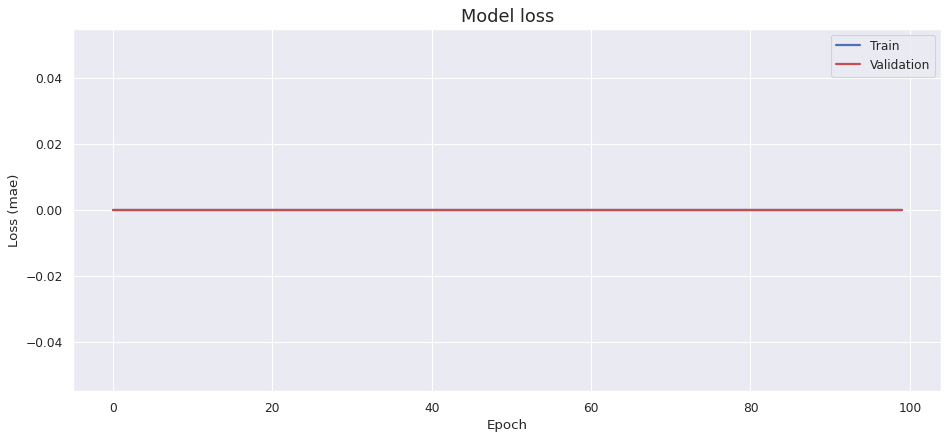

In [33]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# 그만하자....